## EEG IMAGE RECONSTRUCTION

In [1]:
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim import *

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import os
import random
import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output
%matplotlib inline
from chosen_gpu import get_freer_gpu

In [2]:
from chosen_gpu import get_freer_gpu
device = torch.device(get_freer_gpu()) 
print("Configured device: ", device)

Device =  cuda:1


### 1. Define Model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import fnmatch

In [4]:
class Generator(nn.Module):
    """
    Input : random noise / latent vector of any size
    Output : Fake images same size as Real images 
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        
        self.activation = nn.LeakyReLU()
        
        self.fc1 = nn.Sequential (nn.Linear(input_size    , hidden_size )  , self.activation, nn.Dropout(0.3) )
        self.fc2 = nn.Sequential (nn.Linear(hidden_size   , hidden_size*2) , self.activation, nn.Dropout(0.3) )
        self.fc3 = nn.Sequential (nn.Linear(hidden_size*2 , hidden_size*4) , self.activation, nn.Dropout(0.3) )
        self.fc4 = nn.Sequential (nn.Linear(hidden_size*4 , output_size )  , self.activation                  )    
    
    def forward(self, X, noise):
                       
        X = torch.cat([X, noise], dim = 1)
        # print(X.shape)

        X = self.fc1(X)
        X = self.fc2(X)
        X = self.fc3(X)
        X = self.fc4(X)
        X = X.reshape(-1, 3, 28, 28)
        
        return X
    
class Discriminator(nn.Module):
    """
    Input : Real / Fake images
    Output : Classification Real = 1 / Fake = 0
    """
    def __init__(self, input_size, hidden_size):
        super(Discriminator, self).__init__()
        
        self.activation = nn.LeakyReLU()
        
        self.fc1 = nn.Sequential (nn.Linear(input_size, hidden_size*6)      , self.activation, nn.Dropout(0.3))
        self.fc2 = nn.Sequential (nn.Linear(hidden_size*6, hidden_size*4)   , self.activation, nn.Dropout(0.3))
        self.fc3 = nn.Sequential (nn.Linear(hidden_size*4, hidden_size*2)   , self.activation  , nn.Dropout(0.3))
        self.fc4 = nn.Sequential (nn.Linear((hidden_size*2)+32, hidden_size), self.activation  , nn.Dropout(0.3))
        
        self.fc5_0 = nn.Sequential (nn.Linear(hidden_size, 32), self.activation  , nn.Dropout(0.3) )  # for real / fake
        self.fc5_1 = nn.Sequential (nn.Linear(32, 16), self.activation  , nn.Dropout(0.3) )
        self.fc5_2 = nn.Sequential (nn.Linear(16, 8),self.activation  , nn.Dropout(0.3)  ) 
        self.fc5_3 = nn.Sequential (nn.Linear(8, 1)  )
        
        self.fc6_0 = nn.Sequential (nn.Linear(hidden_size, 32) , self.activation  , nn.Dropout(0.3)  ) # for number classification
        self.fc6_1 = nn.Sequential (nn.Linear(32, 6) )
    
    def forward(self, X, latent):       
               
        X = X.flatten(start_dim = 1)

        X = self.fc1(X)
        X = self.fc2(X)
        X = self.fc3(X)
        X = torch.cat([X, latent], dim = 1)                          
        X = self.fc4(X)
        
        rf_decision = self.fc5_0(X)
        rf_decision = self.fc5_1(rf_decision)
        rf_decision = self.fc5_2(rf_decision)
        rf_decision = self.fc5_3(rf_decision)
        
        num_decision = self.fc6_0(X)
        num_decision = self.fc6_1(num_decision)
        
        return rf_decision, num_decision

### 2. Load Stimuli Images

In [5]:
batch_size = 6
# ideal batch size ranges from 32 to 128

torch.Size([6])
tensor([0, 0, 0, 0, 0, 0])
torch.Size([6, 3, 28, 28])


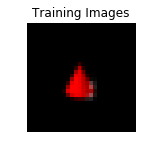

In [6]:
image_size = 28
img_nc     = 1


trsfm = transforms.Compose([transforms.Resize(image_size), 
                            transforms.CenterCrop(image_size),
                            transforms.ToTensor()])

stim_ds     = torchvision.datasets.ImageFolder(root='data/stimuli', transform=trsfm)
stim_loader = torch.utils.data.DataLoader(stim_ds, batch_size = batch_size)

stimiter    = iter(stim_loader)
real_images, actual_y = stimiter.next()

actual_y = actual_y
print(actual_y.shape)
print(actual_y)

print(real_images.shape)

plt.figure(figsize=(2,2))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_images[2].to(device), padding=2, normalize=True).cpu(),(1,2,0)))

### 3. Load the latent EEG features and y labels

In [7]:
EEG_latent = np.load('../weights/HCI/EEG_feature/par1_X.npy')
y          = np.load('../weights/HCI/EEG_feature/par1_y.npy')

print(EEG_latent.shape)
print(y)

(221, 32)
[3 2 1 3 0 1 5 2 3 0 1 5 3 4 5 2 3 3 1 5 2 3 4 2 3 0 4 3 3 0 4 2 3 0 4 1 4
 5 2 3 1 5 0 4 1 3 0 4 1 1 5 0 5 3 0 4 5 3 0 1 2 3 1 5 4 5 0 4 1 0 2 3 4 1
 5 2 0 5 4 3 0 4 5 3 1 5 2 3 4 1 3 4 2 4 5 2 3 0 1 2 4 1 5 3 5 3 4 2 3 0 1
 2 4 1 5 0 4 5 0 4 5 2 1 5 3 4 5 2 4 1 5 2 3 1 5 2 4 1 5 2 0 2 5 2 3 4 5 2
 0 5 2 5 2 0 4 1 5 2 0 2 4 5 2 0 1 2 0 4 1 2 1 5 3 0 1 2 0 4 3 0 4 5 0 5 3
 2 3 0 4 1 1 2 0 3 4 1 3 1 5 2 0 4 0 5 2 0 4 1 5 2 1 2 3 0 4 1 1 2 0 1 5]


In [8]:
torch_X = torch.from_numpy(EEG_latent)
torch_y = torch.from_numpy(y)

In [9]:

ds = TensorDataset(torch_X, torch_y)

latent_loader = DataLoader(ds,
                batch_size = batch_size,
                drop_last  = True, # Drop the last batch if it is not enough for the batch size
                shuffle    = True,
                pin_memory = True) # True = copy Tensors into CUDA pinned memory before returning them

In [10]:
# number of batch
print(len(latent_loader))

dataiter        = iter(latent_loader)
latents, labels = dataiter.next()
print(latents.shape)
print(labels.shape)

36
torch.Size([6, 32])
torch.Size([6])


In [11]:
def do_plot(d_losses, g_losses):
    plt.figure(figsize=(25,5))
#     clear_output(wait=True)
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.title('GAN loss')
    plt.legend()
    plt.show()
    
def random_2D_noise(m,n):
    """
    Random an 2d array of random noise
    =======================
    m = # of samples
    n = # of features
    """
#     mu    = 0 
#     sigma = 1
#     z     = np.random.normal(mu, sigma , size=[m,n])
    z     = np.random.uniform(-1, 1, size=(m,n))
    z     = torch.from_numpy(z).float()
    z     = z.to(device)
    return z


### 4. Test Genterator and discriminator
==========================================================================================

In [12]:
G_net = Generator(input_size = 48, hidden_size = 96 , output_size = 2352).to(device)

noise = random_2D_noise(batch_size, 16)
print(noise.shape)

fake_img = G_net(latents.to(device), noise)
print(fake_img.shape)

torch.Size([6, 16])
torch.Size([6, 3, 28, 28])


In [13]:
D_net = Discriminator(input_size = 2352, hidden_size = 64).to(device)

rf_decision_fake, num_decision_fake = D_net(fake_img, latents.to(device))

print(rf_decision_fake.shape)
print(num_decision_fake.shape)


rf_decision_real, num_decision_real = D_net(real_images.to(device), latents.to(device) )
print(rf_decision_real.shape)
print(num_decision_real.shape)

torch.Size([6, 1])
torch.Size([6, 6])
torch.Size([6, 1])
torch.Size([6, 6])


### 5. Training Parameters 

In [14]:
G_net = Generator(input_size = 48, hidden_size = 96 , output_size = 2352).to(device)
D_net = Discriminator(input_size = 2352, hidden_size = 64).to(device)



noise_size = 16
lr         = 0.0001
G_optimizer = torch.optim.Adam(G_net.parameters(), lr=lr)
D_optimizer = torch.optim.Adam(D_net.parameters(), lr=lr)


BCE_loss_criterion         = nn.BCEWithLogitsLoss().to(device) # use with rf_decision
d_classify_criterion       = nn.CrossEntropyLoss().to(device) # use with num_decision


# For plotting
d_losses    = []
g_losses    = []

g_recon_image_list   = []
eeg_original_labels  = []
gd_class_decision_from_fake_image_list = []
# samples_z = []

# fixed_latent = []
# for i in range(10):
#     temp = latent[torch_y==i]
#     fixed_latent.append(temp)

# fixed_latent = np.array(fixed_latent[0].cpu())
# fixed_latent = torch.from_numpy(fixed_latent).to(device).squeeze()
# fixed_noise = create2D_noise(10, 100) # create 10 noise to check the model performance

In [15]:
# print(G_net)
# print(D_net)


In [16]:
# Number of iterations
NUM_EPOCH   = 100       ## > 50 epoch
print_every = 400

## 6. Train

Epoch : 100/100 | Iteration : 3565 | d_loss: 0.183997 | g_loss: 5.229258


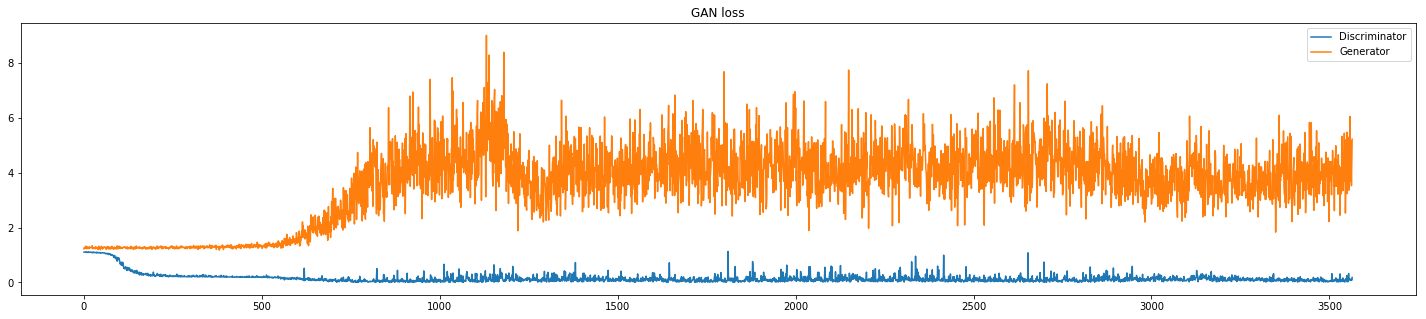

In [17]:
# set G and D in TRAIN MODE ( DO dropout )
G_net.train()
D_net.train()

# noise_latent = random_2D_noise(batch_size, 32)
# zero_latent = torch.from_numpy(np.zeros((batch_size,32) )).to(device).float()

iteration = 0
for epoch in range(NUM_EPOCH):
    
    for batch_i , (eeg_latent, labels ) in enumerate(latent_loader):
        
        G_net.train()
        D_net.train()
        
        # ======== TRAIN DISCRIMINATOR ===========
        D_net.zero_grad()
        G_net.zero_grad()
        D_optimizer.zero_grad()
        
        eeg_latent = eeg_latent.to(device)
        labels     = labels.to(device)

        
        #---------- Train with real image -------
        real_images     = real_images.to(device)
        actual_y        = actual_y.to(device)
        noise_latent    = random_2D_noise(batch_size, 32)
        
        #rf_decision_real_image, num_decision_real_image = D_net(real_images, noise_latent)   
        d_decision_out, d_class_out = D_net(real_images, noise_latent)   
        all_real_labels          = torch.from_numpy(np.ones(d_decision_out.shape)).to(device)
        
        d_loss_with_real_img   = BCE_loss_criterion(       d_decision_out  ,    all_real_labels  )
        d_classify_loss        = d_classify_criterion(     d_class_out  ,    actual_y         )
        
        
        #---------- Train with fake image -------
        noise           = random_2D_noise(batch_size, noise_size)
        d_recon_image   = G_net(eeg_latent, noise)
        
        d_decision_out, d_class_out = D_net(d_recon_image, noise_latent) 
        all_fake_labels             = torch.from_numpy(np.zeros(d_decision_out.shape)).to(device)
        
        d_loss_with_fake_img  = BCE_loss_criterion(d_decision_out, all_fake_labels)
        d_loss                = (d_loss_with_real_img + d_classify_loss + d_loss_with_fake_img)/3
        
        d_loss.backward()
        D_optimizer.step()
        
        d_losses.append(d_loss.item())
        
        
        
        # ======== TRAIN GENERATOR ===========
        D_net.zero_grad()
        G_net.zero_grad()  
        G_optimizer.zero_grad()
        
        noise            = random_2D_noise(batch_size, noise_size)
        G_recon_image    = G_net(eeg_latent, noise)
        
        gd_decision_out, gd_class_decision_from_fake_image = D_net(G_recon_image , eeg_latent)
        gd_class_decision_from_fake_image_list.append(gd_class_decision_from_fake_image)
        
        all_real_labels = torch.from_numpy(np.ones(gd_decision_out.shape)).to(device)
        
        gd_fake_rf_loss = BCE_loss_criterion(gd_decision_out, all_real_labels)
        gd_fake_num_loss= d_classify_criterion(gd_class_decision_from_fake_image, labels)
        
        g_loss          = (gd_fake_rf_loss + gd_fake_num_loss)/2
        g_loss.backward()
        G_optimizer.step()
        
        g_losses.append(g_loss.item())
        eeg_original_labels.append(labels)
        g_recon_image_list.append(G_recon_image)
        
        iteration     += 1
        
        #--------- Display loss---------
        if batch_i % print_every == 0:
            clear_output(wait=True)
            print('Epoch : {:1d}/{:1d} | Iteration : {:1d} | d_loss: {:6.6f} | g_loss: {:6.6f}'.format(epoch+1, NUM_EPOCH, iteration, d_loss.item(), g_loss.item()))
            do_plot(d_losses, g_losses)

            

In [18]:
# print(G_recon_image[-1,0].shape)

# plt.imshow(G_recon_image[-2,0].cpu().detach().numpy())

# print(torch.max(gd_class_decision_from_fake_image_list[-1],dim=1)[1])


# torch.save(G_net.state_dict(), 'save/Generator_dict_0.5s.tar')
# torch.save(D_net.state_dict(), 'save/Discriminator_dict_0.5s.tar')

### 7. Display stim reconstruct of last batch
***

3600
Y oringinal tensor([0, 4, 3, 0, 0, 1], device='cuda:1')
Y predicted tensor([0, 0, 0, 0, 0, 0], device='cuda:1')
Generated image of last batch


(-0.5, 167.5, 27.5, -0.5)

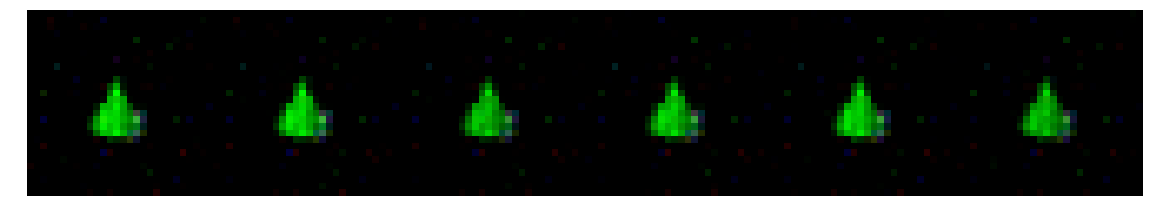

In [19]:
## Display stim reconstruct of last batch

from torchvision.utils import make_grid
from termcolor import colored


print(len(g_recon_image_list))

batch_to_display = 1

images = g_recon_image_list[-batch_to_display]
images = images.cpu()
images = images.reshape(-1, 3, 28, 28)
print(f'Y oringinal {eeg_original_labels[-batch_to_display]}')
print(f'Y predicted {torch.max(gd_class_decision_from_fake_image_list[-batch_to_display],dim=1)[1]}')
print(colored("Generated image of last batch","blue", attrs=['bold']))
grid     = make_grid(images, nrow=10, normalize=True, padding=0)
fig, ax = plt.subplots(figsize=(20,100))
ax.imshow(grid.permute(1, 2, 0).data, cmap='binary')
ax.axis('off')

### 8. Evaluate
***
Test pipline:

eeg_test_set --> encoder--> latent --> Generator --> reconstructed_image --> Discriminator --> h_hat (class) --> calculate accuracy

In [20]:
class EEGEncoder(nn.Module):
    '''
    Expected Input Shape: (batch, channels, height , width)
                          (64   , 16      , 1      , 63   )
    '''
    def __init__(self):
        super().__init__()
        
        self.activation = nn.Tanh()
        
        self.conv1 = nn.Sequential(    nn.Conv1d(16, 32, kernel_size=(1,3),   padding=(0,0), stride=(1,1))  ,  self.activation )
        self.conv2 = nn.Sequential(    nn.Conv1d(32, 64, kernel_size=(1,3) ,  padding=(0,0), stride=(1,1))  ,  self.activation )
        self.fc1   = nn.Sequential(    nn.Linear(384,256),  self.activation ,nn.Dropout(0.1)   ,nn.BatchNorm1d(256)   )
        self.fc2   = nn.Sequential(    nn.Linear(256,128),  self.activation ,nn.Dropout(0.1)   ,nn.BatchNorm1d(128) )
        self.fc3   = nn.Sequential(    nn.Linear(128,64),  self.activation  ,nn.Dropout(0.1)   ,nn.BatchNorm1d(64) )
        self.fc4   = nn.Sequential(    nn.Linear(64,32),  self.activation   ,nn.Dropout(0.1)   ,nn.BatchNorm1d(32) )
        self.fc5   = nn.Sequential(    nn.Linear(32,10)   )

        
        
    
        self.is_debug= False
        
    def encode(self, X):
        
        
        if self.is_debug  : print('--------Convolute--------'); print(X.shape) 
            
        X = self.conv1(X)
        if self.is_debug  : print(X.shape) 
            
        X = self.conv2(X)
        if self.is_debug  : print(X.shape) 
            
        X = X.flatten(start_dim = 1)
        if self.is_debug  : print('--------Flatten--------') ; print(X.shape) 
 
        X = self.fc1(X)
        if self.is_debug : print('--------Flatten--------') ; print(X.shape) 

        X = self.fc2(X)
        if self.is_debug  : print(X.shape) 

        X = self.fc3(X)
        if self.is_debug  : print(X.shape) 
        
        X = self.fc4(X)
        if self.is_debug  : print(X.shape) 

        X = self.fc5(X)
        if self.is_debug  : print(X.shape) 

            
        return X
        
    def forward(self,X):
        X = self.encode(X)
        return X
    
    def get_latent( self, X):
        if self.is_debug  : print('--------Convolute--------'); print(X.shape) 
            
        X = self.conv1(X)
        if self.is_debug  : print(X.shape) 
            
        X = self.conv2(X)
        if self.is_debug  : print(X.shape) 
            
        X = X.flatten(start_dim = 1)
        if self.is_debug  : print('--------Flatten--------') ; print(X.shape) 
 
        X = self.fc1(X)
        if self.is_debug : print('--------Flatten--------') ; print(X.shape) 

        X = self.fc2(X)
        if self.is_debug  : print(X.shape) 

        X = self.fc3(X)
        if self.is_debug  : print(X.shape) 
        
        X = self.fc4(X)
        if self.is_debug  : print(X.shape) 
        
        return X
    
    def classifier(self, latent):
        return self.fc5(latent)
    

In [21]:
### load X_test, labels
X_test            = torch.load('save/eeg_X_test_0.5.pt.tar')
itertest = iter(X_test)
eeg_X_test , labels = itertest.next()
eeg_X_test = eeg_X_test.to(device).float()
labels     = labels.to(device)


### Feed eeg to encoder
model_eeg_encoder = torch.load('save/model_EEGEncoder_network_0.5s.pt.tar').to(device)
model_eeg_encoder.eval()
X_test_latent     = model_eeg_encoder.get_latent(eeg_X_test)


### Feed latent to Generator
G_net_test       = Generator(input_size = 48, hidden_size = 96, output_size = 784).to(device)
G_net_test.eval()
noise            = random_2D_noise(X_test_latent.shape[0], noise_size)
G_net_test.eval()
G_net_test.load_state_dict(torch.load('save/Generator_dict_0.5s.tar'))
g_imag_recon     = G_net_test(X_test_latent, noise)


#### Feed image reconstruction to discriminator
D_net_test      = Discriminator(input_size = 784, hidden_size = 64 ).to(device)
D_net_test.eval()
D_net_test.load_state_dict(torch.load('save/Discriminator_dict_0.5s.tar'))
d_test_decision , d_class_decision_from_fake_image = D_net(g_imag_recon , X_test_latent)

# Generator Cheating score
sigmoid        = nn.Sigmoid()
decision       = torch.round(sigmoid(d_test_decision))
decision       = decision.cpu().detach().numpy()
generator_won  = np.count_nonzero(decision)*100/decision.shape[0]
print(f'Generator won scrore  :\t {generator_won:4.4f} %')

# Accuracy of class decision
LogSoftMax     = nn.LogSoftmax()
d_class        = LogSoftMax(d_class_decision_from_fake_image)
_ , d_class    = torch.max(d_class, dim=1)
class_correct  = (d_class == labels).sum().item()  #.item() give the raw number
class_acc      = 100 * (class_correct / len(labels))
print(f'Classifier accuracy   :\t {class_acc:4.4f} %')

FileNotFoundError: [Errno 2] No such file or directory: 'save/eeg_X_test_0.5.pt.tar'

In [ ]:
torch.cuda.empty_cache()